In [3]:
import numpy as np
from nilearn import datasets, plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.interfaces.fmriprep import load_confounds
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [4]:
# Load Schaefer atlas
atlas_data = datasets.fetch_atlas_schaefer_2018(n_rois=400)
atlas_filename = atlas_data.maps

# Load fMRI data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=False)
fmri_filenames = data.func[0]

# Define the masker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, verbose=5)

 

In [5]:

pd.read_csv(data.confounds[0], sep='\t').head()

compcorr = [col for col in pd.read_csv(data.confounds[0], sep='\t').columns if 'comp_cor' in col]
print(compcorr)

['t_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02', 't_comp_cor_03', 't_comp_cor_04', 't_comp_cor_05', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']


In [6]:
# Confound 1: Global Signal Regression
confounds_gsr = load_confounds(fmri_filenames,
                                strategy=['global_signal',"high_pass", "wm_csf"])
# Confound 2: Motion Parameters
confounds_motion = load_confounds(fmri_filenames,strategy=['motion',"high_pass", "wm_csf"], motion= "basic", compcor='anat_combined',n_compcor='all')



In [7]:
print(confounds_motion)

(     cosine00  cosine01  cosine02  cosine03       csf     rot_x     rot_y  \
0    0.109104  0.109090  0.109066  0.109033 -2.675004  0.000304  0.000583   
1    0.109066  0.108937  0.108723  0.108423 -2.902773 -0.000316  0.000418   
2    0.108990  0.108632  0.108038  0.107207 -2.629915 -0.000285  0.000595   
3    0.108875  0.108176  0.107012  0.105391 -1.601793 -0.000226  0.001049   
4    0.108723  0.107567  0.105651  0.102986 -2.258970 -0.000245  0.000779   
..        ...       ...       ...       ...       ...       ...       ...   
163 -0.108723  0.107567 -0.105651  0.102986  2.445759 -0.000299 -0.000335   
164 -0.108875  0.108176 -0.107012  0.105391  2.244003  0.000406 -0.000279   
165 -0.108990  0.108632 -0.108038  0.107207  3.390256 -0.000163 -0.000574   
166 -0.109066  0.108937 -0.108723  0.108423  3.485434  0.000857 -0.000557   
167 -0.109104  0.109090 -0.109066  0.109033  0.402734 -0.000428 -0.000256   

        rot_z   trans_x   trans_y   trans_z  white_matter  
0    0.000201 

In [8]:

time_series_gsr = masker.fit_transform(fmri_filenames, confounds=confounds_gsr[0])
time_series_motion = masker.fit_transform(fmri_filenames, confounds=confounds_motion[0])



[NiftiLabelsMasker.wrapped] loading data from C:\Users\prsyu\nilearn_data\schaefer_2018\Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from C:\Users\prsyu\nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiLabelsMasker.wrapped] loading data from C:\Users\prsyu\nilearn_data\schaefer_2018\Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from C:\Users\prsyu\nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals


In [9]:
# Calculate connectivity matrices
connectivity_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix_gsr = connectivity_measure.fit_transform([time_series_gsr])[0]
correlation_matrix_motion = connectivity_measure.fit_transform([time_series_motion])[0]


In [10]:
time_series_gsr[0].shape


(400,)

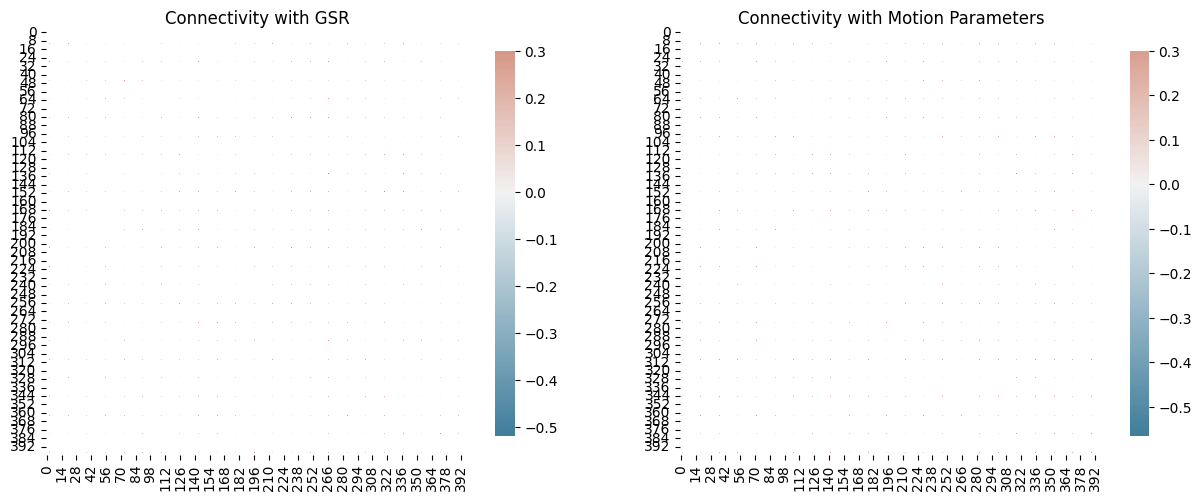

In [14]:
# Zero out the diagonals
np.fill_diagonal(correlation_matrix_gsr, 0)
np.fill_diagonal(correlation_matrix_motion, 0)

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmaps with the correct aspect ratio
sns.heatmap(correlation_matrix_gsr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[0]).set_title('Connectivity with GSR')
sns.heatmap(correlation_matrix_motion, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[1]).set_title('Connectivity with Motion Parameters')

plt.show()

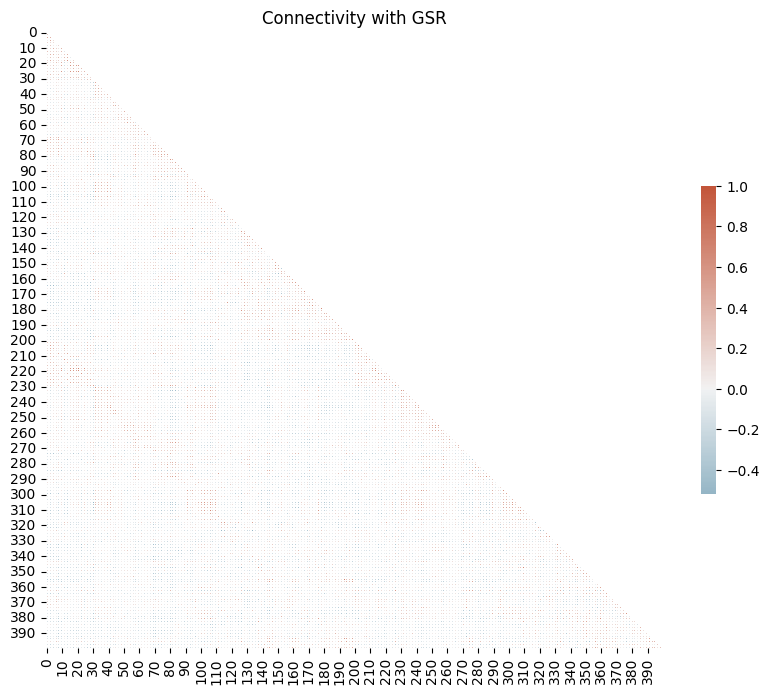

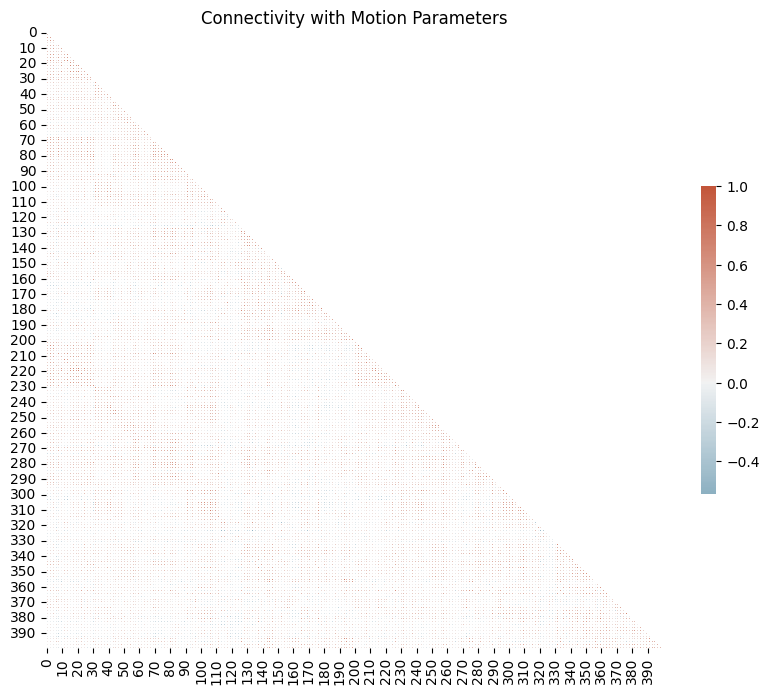

In [23]:
def create_plot(matrix, title):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the size as needed

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(matrix, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax.set_title(title)
    plt.show()

# Create the first plot
create_plot(correlation_matrix_gsr, 'Connectivity with GSR')

# Create the second plot
create_plot(correlation_matrix_motion, 'Connectivity with Motion Parameters')

In [35]:


# Check for NaN values in correlation_matrix_gsr
if np.isnan(correlation_matrix_gsr).any():
    print("correlation_matrix_gsr contains NaN values")
else:
    print("correlation_matrix_gsr does not contain NaN values")

# Check for NaN values in correlation_matrix_motion
if np.isnan(correlation_matrix_motion).any():
    print("correlation_matrix_motion contains NaN values")
else:
    print("correlation_matrix_motion does not contain NaN values")


correlation_matrix_gsr does not contain NaN values
correlation_matrix_motion does not contain NaN values


In [38]:
min_corr_gsr = np.min(correlation_matrix_gsr)
max_corr_gsr = np.max(correlation_matrix_gsr)

min_corr_motion = np.min(correlation_matrix_motion)
max_corr_motion = np.max(correlation_matrix_motion)

print("Minimum correlation (GSR):", min_corr_gsr)
print("Maximum correlation (GSR):", max_corr_gsr)

print("Minimum correlation (Motion Parameters):", min_corr_motion)
print("Maximum correlation (Motion Parameters):", max_corr_motion)


Minimum correlation (GSR): -0.5178317047265016
Maximum correlation (GSR): 0.7479905780576978
Minimum correlation (Motion Parameters): -0.5649858344325137
Maximum correlation (Motion Parameters): 0.7875434181662583


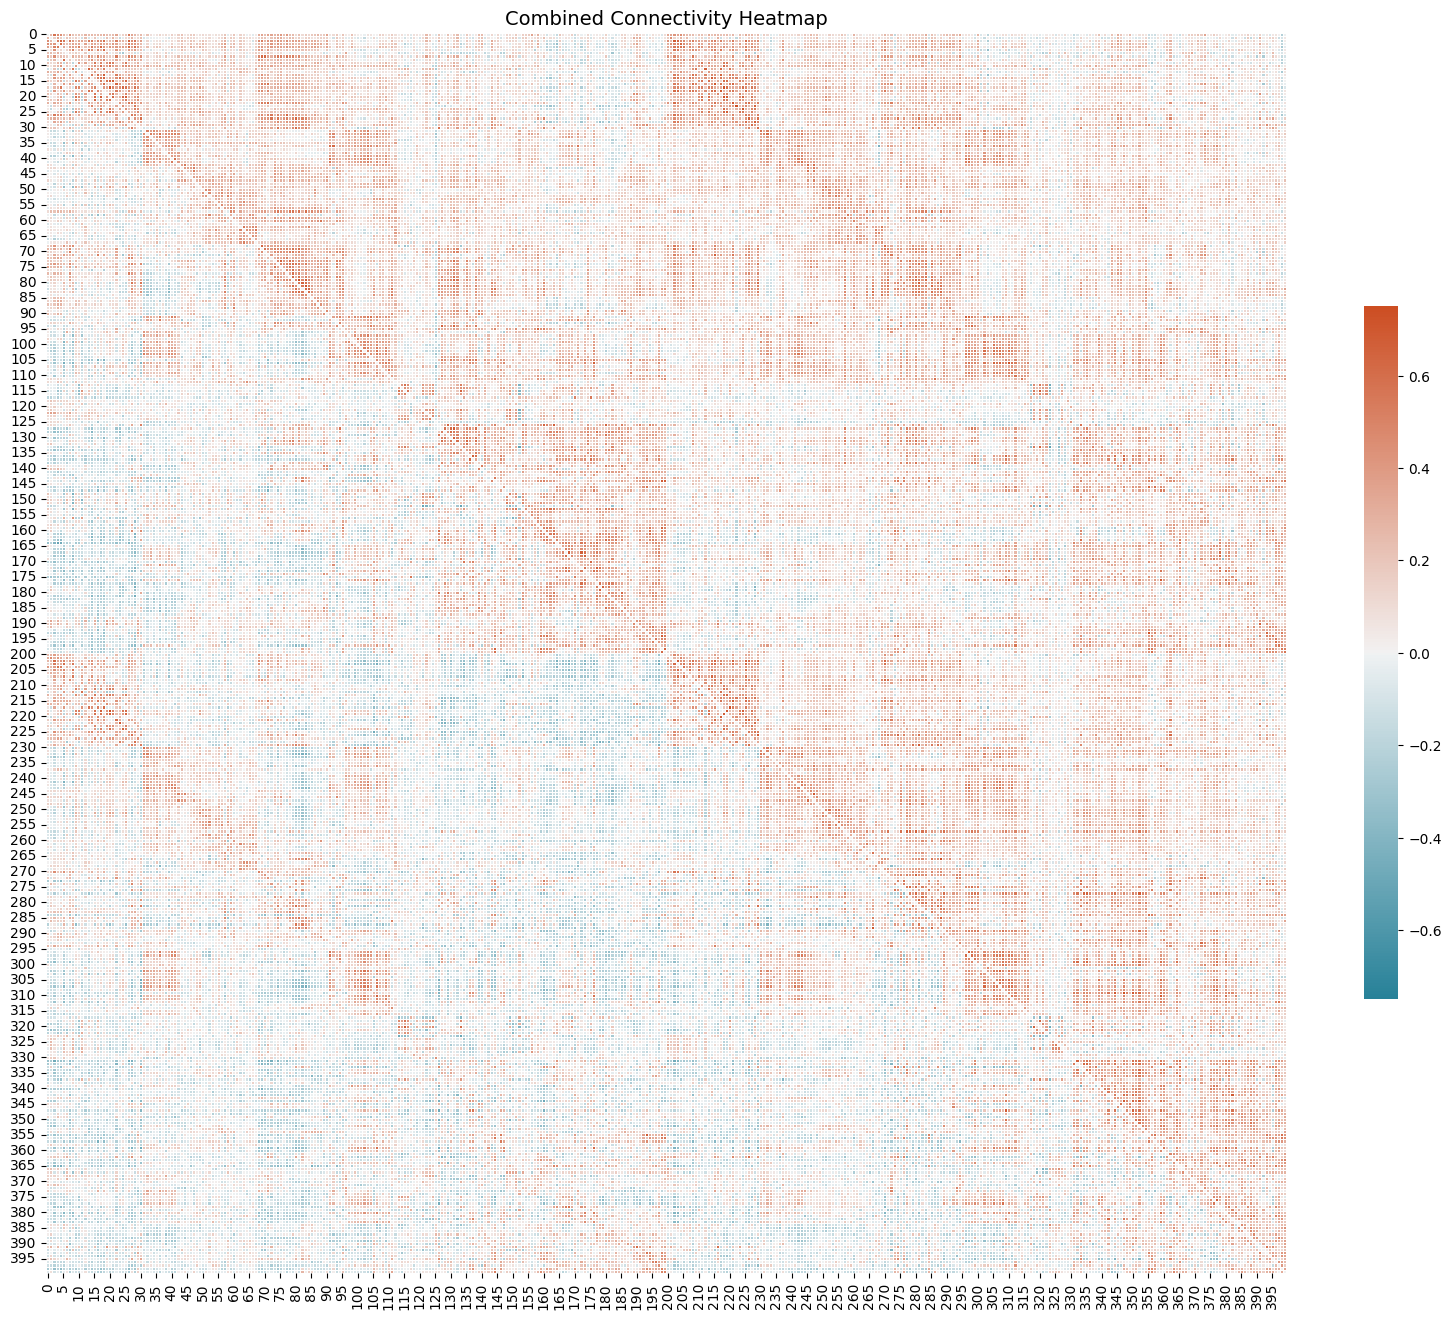

In [45]:

def create_combined_plot(matrix1, matrix2, title):
    # Assuming matrix1 and matrix2 are numpy arrays of the same shape
    n = matrix1.shape[0]
    
    # Create a new matrix that will hold both correlations
    combined_matrix = np.zeros_like(matrix1)
    
    # Fill the lower triangle of the combined matrix with matrix1
    combined_matrix[np.tril_indices(n, -1)] = matrix1[np.tril_indices(n, -1)]
    
    # Fill the upper triangle of the combined matrix with matrix2
    combined_matrix[np.triu_indices(n, 1)] = matrix2[np.triu_indices(n, 1)]
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 18))  # Adjust the size as needed
    
    # Generate a custom diverging colormap with high contrast
    cmap = sns.diverging_palette(220, 20, l=50, s=90, as_cmap=True)

    # Draw the heatmap without a mask, with the correct aspect ratio
    sns.heatmap(combined_matrix, cmap=cmap, vmax=0.75, vmin=-0.75, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # Enhance visualization
    plt.xticks(fontsize=10)  # Smaller font size
    plt.yticks(fontsize=10)  # Smaller font size
    ax.set_title(title, fontsize=14)

    plt.show()

# Assuming correlation_matrix_gsr and correlation_matrix_motion are defined
create_combined_plot(correlation_matrix_gsr, correlation_matrix_motion, 'Combined Connectivity Heatmap')
